In [1]:
# Cell 1 — setup
import os, random, json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision import models
from pathlib import Path
from tqdm import tqdm

# determinism: every roll of the dice is the same tomorrow
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# dataset root (specific to your Kaggle dataset)
DATA_DIR = Path("/kaggle/input/raf-db-dataset/DATASET")

# canonical emotion order — the “basis vectors” of affective space
COMMON = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
label2idx = {name:i for i,name in enumerate(COMMON)}
idx2label = {i:name for name,i in label2idx.items()}

# numeric RAF folder label → common name
raf_num_to_name = {1:'Surprise',2:'Fear',3:'Disgust',4:'Happy',5:'Sad',6:'Angry',7:'Neutral'}

# hyperparameters — knobs of experimentation
IMG_SIZE = 224
BATCH_SIZE = 64
LR_HEAD = 1e-3
LR_FULL = 1e-4
EPOCHS_STAGE1 = 5
EPOCHS_STAGE2 = 20
WEIGHT_DECAY = 1e-4


Using device: cuda


In [2]:
# Cell 2 — build records from CSV (or fallback to folder structure)
import pandas as pd
from pathlib import Path
from collections import Counter

DATASET_ROOT = Path("/kaggle/input/raf-db-dataset")
CSV_TRAIN = DATASET_ROOT / "train_labels.csv"
CSV_TEST  = DATASET_ROOT / "test_labels.csv"
IMAGES_BASE = Path("/kaggle/input/raf-db-dataset/DATASET")  # matches Cell 1

def build_records_from_csv(csv_path, split_name):
    df = pd.read_csv(csv_path)
    # print df columns once so you can adjust if needed
    print(f"\nLoaded {csv_path.name} — columns:", list(df.columns))
    # heuristics for common column names
    if 'image' in df.columns and 'label' in df.columns:
        img_col, label_col = 'image', 'label'
    elif df.shape[1] >= 2:
        img_col, label_col = df.columns[0], df.columns[1]
    else:
        raise ValueError("CSV format unexpected. Inspect df.head() manually.")
    records = []
    missed = 0
    for _, row in df.iterrows():
        fname = str(row[img_col]).strip()
        try:
            raw_label = int(row[label_col])
        except:
            # try cleaning non-numeric labels
            try:
                raw_label = int(float(row[label_col]))
            except:
                continue
        if raw_label not in raf_num_to_name:
            continue
        label_name = raf_num_to_name[raw_label]
        label_idx = label2idx[label_name]
        img_path = IMAGES_BASE / split_name / str(raw_label) / fname
        if img_path.exists():
            records.append((str(img_path), label_idx))
        else:
            # fallback: try to glob for a matching stem within the expected class folder
            stem = Path(fname).stem
            alt = list((IMAGES_BASE / split_name / str(raw_label)).glob(f"{stem}*"))
            if alt:
                records.append((str(alt[0]), label_idx))
            else:
                missed += 1
    print(f"Parsed {len(records)} records from {csv_path.name}; missed {missed} entries (missing files).")
    return records

if CSV_TRAIN.exists() and CSV_TEST.exists():
    train_records = build_records_from_csv(CSV_TRAIN, "train")
    val_records   = build_records_from_csv(CSV_TEST,  "test")
else:
    # fallback to folder inference
    print("CSV labels not found — inferring from folder layout.")
    train_records, val_records = [], []
    for split in ["train", "test"]:
        root = IMAGES_BASE / split
        if not root.exists():
            continue
        for class_dir in sorted(root.iterdir()):
            if not class_dir.is_dir(): continue
            try:
                raw_label = int(class_dir.name)
            except:
                continue
            if raw_label not in raf_num_to_name: continue
            label_idx = label2idx[raf_num_to_name[raw_label]]
            for img in class_dir.glob("*aligned.*"):
                if split == "train":
                    train_records.append((str(img), label_idx))
                else:
                    val_records.append((str(img), label_idx))
    print(f"Inferred train={len(train_records)}, val={len(val_records)} from folders.")

# quick sanity checks and prints
print("\nSanity check:")
print("Train samples:", len(train_records))
print("Val   samples:", len(val_records))
print("Train class counts:", Counter([r[1] for r in train_records]))
print("Val   class counts:",   Counter([r[1] for r in val_records]))
print("\nFirst 5 train records (path, label_idx):")
for r in train_records[:5]:
    print(r)
print("\nFirst 5 val records (path, label_idx):")
for r in val_records[:5]:
    print(r)



Loaded train_labels.csv — columns: ['image', 'label']
Parsed 12271 records from train_labels.csv; missed 0 entries (missing files).

Loaded test_labels.csv — columns: ['image', 'label']
Parsed 3068 records from test_labels.csv; missed 0 entries (missing files).

Sanity check:
Train samples: 12271
Val   samples: 3068
Train class counts: Counter({3: 4772, 6: 2524, 4: 1982, 5: 1290, 1: 717, 0: 705, 2: 281})
Val   class counts: Counter({3: 1185, 6: 680, 4: 478, 5: 329, 0: 162, 1: 160, 2: 74})

First 5 train records (path, label_idx):
('/kaggle/input/raf-db-dataset/DATASET/train/5/train_00001_aligned.jpg', 4)
('/kaggle/input/raf-db-dataset/DATASET/train/5/train_00002_aligned.jpg', 4)
('/kaggle/input/raf-db-dataset/DATASET/train/4/train_00003_aligned.jpg', 3)
('/kaggle/input/raf-db-dataset/DATASET/train/4/train_00004_aligned.jpg', 3)
('/kaggle/input/raf-db-dataset/DATASET/train/5/train_00005_aligned.jpg', 4)

First 5 val records (path, label_idx):
('/kaggle/input/raf-db-dataset/DATASET/test

In [3]:
# Cell 3 — Dataset class, transforms, and dataloaders
from PIL import Image
from torch.utils.data import WeightedRandomSampler
import torchvision.transforms as T
from collections import Counter

# transforms: modest augmentation for real faces (not circus augmentation)
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.85,1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.15,0.15,0.15,0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class RAFDataset(torch.utils.data.Dataset):
    def __init__(self, records, transform=None):
        self.records = records
        self.transform = transform
    def __len__(self):
        return len(self.records)
    def __getitem__(self, idx):
        p, lbl = self.records[idx]
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, lbl

train_ds = RAFDataset(train_records, transform=train_transforms)
val_ds   = RAFDataset(val_records, transform=val_transforms)

# class-weighted sampler to address imbalance
train_labels = [r[1] for r in train_records]
class_counts = Counter(train_labels)
print("Train class counts (index->count):", dict(class_counts))
class_sample_count = np.array([class_counts[i] if i in class_counts else 0 for i in range(len(COMMON))])
class_weights = 1.0 / (class_sample_count + 1e-9)
samples_weight = np.array([class_weights[t] for t in train_labels])
samples_weight = torch.from_numpy(samples_weight).double()
sampler = WeightedRandomSampler(samples_weight, num_samples=len(samples_weight), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# quick sanity check
xb, yb = next(iter(val_loader))
print("Batch shapes — images:", xb.shape, "labels:", yb.shape)
print("Example label distribution in this val batch:", Counter(yb.tolist()))


Train class counts (index->count): {4: 1982, 3: 4772, 5: 1290, 0: 705, 2: 281, 1: 717, 6: 2524}
Batch shapes — images: torch.Size([64, 3, 224, 224]) labels: torch.Size([64])
Example label distribution in this val batch: Counter({3: 35, 4: 12, 5: 9, 0: 5, 1: 3})


In [4]:
# Cell 4 — build model, print sizes, setup loss & optimizer for head-only training
import torch.nn as nn
from torchvision import models

def build_resnet(num_classes=len(COMMON), backbone='resnet18', pretrained_backbone=True):
    if backbone == 'resnet18':
        model = models.resnet18(pretrained=pretrained_backbone)
    elif backbone == 'resnet50':
        model = models.resnet50(pretrained=pretrained_backbone)
    else:
        raise ValueError("Unsupported backbone")
    # replace final layer with our emotion head
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

# choose pretrained_backbone=True if you want ImageNet features (recommended if allowed)
model = build_resnet(num_classes=len(COMMON), backbone='resnet18', pretrained_backbone=True)
model = model.to(DEVICE)

# count params (for sanity)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}  |  Trainable params: {trainable_params:,}")

# Freeze backbone for Stage 1: only train the final fc
for name, p in model.named_parameters():
    if 'fc' in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

# loss & optimizer for head-only
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR_HEAD, weight_decay=WEIGHT_DECAY)

# small utility: save initial weights (handy for experiments)
init_path = "/kaggle/working/raf_init_state.pth"
torch.save(model.state_dict(), init_path)
print("Saved initial state to", init_path)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s] 


Total params: 11,180,103  |  Trainable params: 11,180,103
Saved initial state to /kaggle/working/raf_init_state.pth


In [5]:
# Cell 5 — Stage 1: train final head only (short, stable)
import time
from collections import defaultdict
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

best_val_acc = 0.0
history = defaultdict(list)

def train_one_epoch_head(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    return running_loss / total, correct / total

# run Stage 1
start_time = time.time()
for epoch in range(1, EPOCHS_STAGE1 + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch_head(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
    took = time.time() - t0
    print(f"[Stage1] Epoch {epoch}/{EPOCHS_STAGE1} — train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}  ({took:.1f}s)")
    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/raf_best_stage1.pth")
        print("  Saved best head -> /kaggle/working/raf_best_stage1.pth")
total_time = time.time() - start_time
print(f"Stage 1 complete — best val acc: {best_val_acc:.4f} — elapsed {total_time/60:.2f} min")


/tmp/ipykernel_37/3433403866.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipykernel_37/3433403866.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_37/3433403866.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Stage1] Epoch 1/5 — train_loss=1.7120, train_acc=0.3344 | val_loss=1.7620, val_acc=0.3103  (53.6s)
  Saved best head -> /kaggle/working/raf_best_stage1.pth
[Stage1] Epoch 2/5 — train_loss=1.5135, train_acc=0.4290 | val_loss=1.4593, val_acc=0.4521  (47.3s)
  Saved best head -> /kaggle/working/raf_best_stage1.pth
[Stage1] Epoch 3/5 — train_loss=1.4607, train_acc=0.4516 | val_loss=1.4639, val_acc=0.4436  (46.5s)
[Stage1] Epoch 4/5 — train_loss=1.4384, train_acc=0.4692 | val_loss=1.5614, val_acc=0.3918  (46.5s)
[Stage1] Epoch 5/5 — train_loss=1.4138, train_acc=0.4753 | val_loss=1.4974, val_acc=0.4257  (45.2s)
Stage 1 complete — best val acc: 0.4521 — elapsed 3.99 min


/tmp/ipykernel_37/3807098152.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipykernel_37/3807098152.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


[Stage2] Epoch 1/20 — train_loss=0.8684 train_acc=0.6912 | val_loss=0.8250 val_acc=0.7089  (48.5s)
  Saved best -> /kaggle/working/raf_best.pth
[Stage2] Epoch 2/20 — train_loss=0.4684 train_acc=0.8391 | val_loss=0.7413 val_acc=0.7493  (50.5s)
  Saved best -> /kaggle/working/raf_best.pth
[Stage2] Epoch 3/20 — train_loss=0.3294 train_acc=0.8853 | val_loss=0.6532 val_acc=0.7735  (51.0s)
  Saved best -> /kaggle/working/raf_best.pth
[Stage2] Epoch 4/20 — train_loss=0.2330 train_acc=0.9213 | val_loss=0.6433 val_acc=0.7960  (48.5s)
  Saved best -> /kaggle/working/raf_best.pth
[Stage2] Epoch 5/20 — train_loss=0.1858 train_acc=0.9389 | val_loss=0.6541 val_acc=0.7947  (49.5s)
[Stage2] Epoch 6/20 — train_loss=0.1364 train_acc=0.9545 | val_loss=0.6360 val_acc=0.8044  (48.9s)
  Saved best -> /kaggle/working/raf_best.pth
[Stage2] Epoch 7/20 — train_loss=0.1147 train_acc=0.9610 | val_loss=0.6407 val_acc=0.8080  (48.8s)
  Saved best -> /kaggle/working/raf_best.pth
[Stage2] Epoch 8/20 — train_loss=0.09

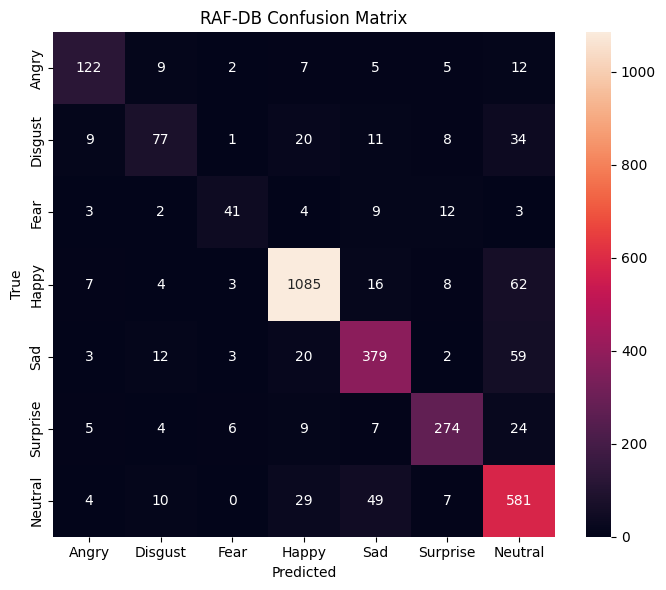

ONNX exported to /kaggle/working/raf_model.onnx
Saved artifacts: raf_final_state_dict.pth, raf_label_map.json, (raf_model.onnx if export succeeded).


In [6]:
# Cell 6 — Stage 2: unfreeze all, fine-tune, evaluate, export
import time
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# unfreeze entire model
for p in model.parameters():
    p.requires_grad = True

# optimizer & scheduler for full fine-tune
optimizer = torch.optim.Adam(model.parameters(), lr=LR_FULL, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS_STAGE2)

# simple early stopping
best_val_acc = 0.0
best_epoch = 0
patience = 5
no_improve = 0

def train_one_epoch_full(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

def evaluate_full(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(imgs)
                loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds_all.extend(logits.argmax(dim=1).cpu().numpy().tolist())
            labels_all.extend(labels.cpu().numpy().tolist())
    acc = (np.array(preds_all) == np.array(labels_all)).mean()
    return running_loss / len(labels_all), acc, np.array(preds_all), np.array(labels_all)

# run Stage 2
start_time = time.time()
for epoch in range(1, EPOCHS_STAGE2 + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch_full(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_preds, val_labels = evaluate_full(model, val_loader, criterion)
    scheduler.step()

    print(f"[Stage2] Epoch {epoch}/{EPOCHS_STAGE2} — train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f}  ({time.time()-t0:.1f}s)")

    # checkpoint best
    if val_acc > best_val_acc + 1e-5:
        best_val_acc = val_acc
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), "/kaggle/working/raf_best.pth")
        print("  Saved best -> /kaggle/working/raf_best.pth")
    else:
        no_improve += 1
    if no_improve >= patience:
        print(f"Stopping early at epoch {epoch} (no improvement for {patience} epochs).")
        break

total_time = time.time() - start_time
print(f"Stage 2 finished in {total_time/60:.2f} min. Best val acc: {best_val_acc:.4f} at epoch {best_epoch}")

# Load best and run final evaluation + report
best_path = "/kaggle/working/raf_best.pth"
if Path(best_path).exists():
    model.load_state_dict(torch.load(best_path, map_location=DEVICE))
else:
    print("Warning: best checkpoint not found, using current weights.")

val_loss, val_acc, val_preds, val_labels = evaluate_full(model, val_loader, criterion)
print(f"Final eval — val_loss={val_loss:.4f}, val_acc={val_acc:.4f}\n")
print(classification_report(val_labels, val_preds, target_names=[idx2label[i] for i in range(len(COMMON))], digits=4))

# confusion matrix plot
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=[idx2label[i] for i in range(len(COMMON))], yticklabels=[idx2label[i] for i in range(len(COMMON))])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("RAF-DB Confusion Matrix")
plt.tight_layout()
plt.savefig("/kaggle/working/raf_confusion_matrix.png", dpi=150)
plt.show()

# export artifacts: state_dict, ONNX, label map
torch.save(model.state_dict(), "/kaggle/working/raf_final_state_dict.pth")
with open("/kaggle/working/raf_label_map.json", "w") as f:
    json.dump({"idx2label": idx2label, "label2idx": label2idx}, f)

# ONNX export (best-effort)
try:
    model.eval()
    dummy = torch.randn(1,3,IMG_SIZE,IMG_SIZE, device=DEVICE)
    torch.onnx.export(model, dummy, "/kaggle/working/raf_model.onnx", input_names=['input'], output_names=['logits'], opset_version=13)
    print("ONNX exported to /kaggle/working/raf_model.onnx")
except Exception as e:
    print("ONNX export failed:", e)

print("Saved artifacts: raf_final_state_dict.pth, raf_label_map.json, (raf_model.onnx if export succeeded).")


In [7]:
# Cell 7 — inference helper: lo  ads state_dict and predicts (returns label, probs)
import torch
import torch.nn.functional as F
from PIL import Image

# reuse val_transforms from earlier cells
def load_model_for_inference(state_path="/kaggle/working/raf_best.pth", device=DEVICE):
    m = build_resnet(num_classes=len(COMMON), backbone='resnet18', pretrained_backbone=False)
    m.load_state_dict(torch.load(state_path, map_location=device))
    m.to(device).eval()
    return m

model_infer = load_model_for_inference("/kaggle/working/raf_best.pth", DEVICE)

def predict_image(model, img_pil, transforms=val_transforms, device=DEVICE):
    """
    img_pil: PIL.Image in RGB
    returns: (pred_idx, pred_label, probs_dict)
    """
    x = transforms(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    pred_idx = int(probs.argmax())
    pred_label = idx2label[pred_idx]
    probs_dict = {idx2label[i]: float(probs[i]) for i in range(len(COMMON))}
    return pred_idx, pred_label, probs_dict

# quick test (use one sample from val_records)
sample_path = val_records[0][0]
img = Image.open(sample_path).convert("RGB")
print("Ground truth idx:", val_records[0][1], "->", idx2label[val_records[0][1]])
print("Prediction:", predict_image(model_infer, img))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Ground truth idx: 4 -> Sad
Prediction: (4, 'Sad', {'Angry': 1.8562230863494733e-08, 'Disgust': 4.825943960895529e-06, 'Fear': 3.4894837881438434e-05, 'Happy': 2.997567207785323e-07, 'Sad': 0.9998688697814941, 'Surprise': 1.3703637478101882e-06, 'Neutral': 8.964612061390653e-05})


In [8]:
# Cell 8 — face detect + crop utility
# preferred: facenet-pytorch MTCNN (better boxes). fallback: OpenCV Haar cascade (worse but available).
try:
    from facenet_pytorch import MTCNN
    mtcnn = MTCNN(keep_all=False, device=DEVICE)
    def detect_and_crop_mtcnn(img_pil):
        # returns PIL crop or None
        box = mtcnn.detect(img_pil)[0]
        if box is None or len(box) == 0:
            return None
        b = box[0]  # x1,y1,x2,y2
        x1,y1,x2,y2 = map(int, b)
        crop = img_pil.crop((x1, y1, x2, y2))
        return crop
    detect_and_crop = detect_and_crop_mtcnn
    print("Using MTCNN for face detection.")
except Exception:
    import cv2
    haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(haar_path)
    def detect_and_crop_haar(img_pil):
        img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
        if len(faces) == 0:
            return None
        x,y,w,h = faces[0]
        crop = Image.fromarray(cv2.cvtColor(img[y:y+h, x:x+w], cv2.COLOR_BGR2RGB))
        return crop
    detect_and_crop = detect_and_crop_haar
    print("MTCNN not available — using OpenCV Haar cascade fallback.")

# example: detect + predict pipeline
def detect_predict(path_or_pil):
    img_pil = Image.open(path_or_pil).convert("RGB") if isinstance(path_or_pil, (str, Path)) else path_or_pil
    face = detect_and_crop(img_pil)
    if face is None:
        return None  # no face found
    return predict_image(model_infer, face)

# quick demo (first val image)
res = detect_predict(sample_path)
print("detect_predict result:", res)


MTCNN not available — using OpenCV Haar cascade fallback.
detect_predict result: None


In [9]:
# Cell 9 — TorchScript export (trace) and size check
import torch
ts_path = "/kaggle/working/raf_model_ts.pt"
try:
    # make a cpu copy for tracing (safer)
    cpu_model = build_resnet(num_classes=len(COMMON), backbone='resnet18', pretrained_backbone=False)
    cpu_model.load_state_dict(torch.load("/kaggle/working/raf_best.pth", map_location="cpu"))
    cpu_model.eval()
    example = torch.randn(1,3,IMG_SIZE,IMG_SIZE)
    traced = torch.jit.trace(cpu_model, example)
    traced.save(ts_path)
    print("Saved TorchScript to", ts_path, "size (MB):", round((Path(ts_path).stat().st_size / (1024*1024)), 2))
except Exception as e:
    print("TorchScript export failed:", e)

# Optional: post-training static quantization (PyTorch) — quick recipe (run if you want smaller model)
# 1) Fuse modules (if using resnet, torch.quantization.fuse_modules available),
# 2) Prepare/convert with quantization-aware or post-training quantization APIs.
# Short hint: use ONNX + ONNXRuntime quantize or PyTorch dynamic quantization for linear-only speedups:
try:
    import torch.quantization as tq
    dq_model = cpu_model  # dynamic quantize
    dq_model.eval()
    dq_model_int8 = torch.quantization.quantize_dynamic(dq_model, {torch.nn.Linear}, dtype=torch.qint8)
    qpath = "/kaggle/working/raf_model_dynamic_quant.pth"
    torch.save(dq_model_int8.state_dict(), qpath)
    print("Saved dynamic-quant model state (linear-quantized) to", qpath)
except Exception:
    pass  # optional step; ignore if toolchain not available


Saved TorchScript to /kaggle/working/raf_model_ts.pt size (MB): 42.84
Saved dynamic-quant model state (linear-quantized) to /kaggle/working/raf_model_dynamic_quant.pth


In [10]:
# download instructions (run in terminal or follow Kaggle UI):
# - In Notebook > Output Files, click the files to download.
# - Or, in a cell, zip artifacts:
!zip -r /kaggle/working/raf_artifacts.zip /kaggle/working/raf_best.pth /kaggle/working/raf_model_ts.pt /kaggle/working/raf_model.onnx /kaggle/working/raf_label_map.json
# Then download raf_artifacts.zip from the Output pane.


  adding: kaggle/working/raf_best.pth (deflated 7%)
  adding: kaggle/working/raf_model_ts.pt (deflated 7%)
  adding: kaggle/working/raf_model.onnx (deflated 7%)
  adding: kaggle/working/raf_label_map.json (deflated 38%)
